In [28]:
# Import modules for HTML display in the notebook and enable inline mode for Matplotlib
from IPython.display import display, HTML, Math, Latex
from IPython.core.magic import register_cell_magic
  
%matplotlib inline

# Import common libraries for data manipulation, optimization, and control
import pandas as pd  # type: ignore
import cvxpy as cp  # type: ignore
from matplotlib.ticker import FuncFormatter, MultipleLocator  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import numpy as np  # type: ignore
import matplotlib as mpl  # type: ignore
from matplotlib.patches import FancyArrowPatch # type: ignore
from scipy.integrate import quad # type: ignore
import importlib
import itertools
import csv
import concurrent.futures
from scipy.spatial import ConvexHull
import os, math, sys
import json
from scipy.interpolate import interp1d
from scipy.interpolate import interp1d
import numpy as np
import json
from typing import Dict, List, Any, Optional, Literal


from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

utils_path = os.path.abspath(os.path.join("..", "Utils"))
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Import utility functions from custom modules
import Tex as tex
import Graphs as gph
import Signal as sgn
import Numeric as nm

importlib.reload(tex)
importlib.reload(gph)
importlib.reload(sgn)
importlib.reload(nm)

# Attempt to configure LaTeX for text rendering, otherwise use default Matplotlib fonts
gph.use_latex()

# Set the resolution of figures generated by Matplotlib
mpl.rcParams['figure.dpi'] = 100

 # === Gráficos ===
cfg = {
  'style': { 'color': 'black', },
  'axis': { 'title_pad': 10, 'y_digits': 1, 'x_digits': 0,
            'x_label_fontsize': 16,
            'y_label_fontsize': 16,
            'tick_fontsize': 16,},
  'limits': { 'x_min': 0., 'x_max': 0.1,}
}



@register_cell_magic
def skip(line, cell):
  return

LaTeX has been enabled for text rendering.


In [11]:
def get_dg_unit_params(R, L, Rt, Lt, Ct, Y, vdc, Be, Pl, vo):
  # Cálculo dos pontos de operação
  io = []
  n = 2
  m = 1
  for k in range(m):
    _io = 0.
    for j in range(n):
      _io += Be[j][k] * vo[j]
    io += [(1. / R[k]) * _io]

  # Corrente do indutor de cada unidade
  it_o = []
  for i in range(n):
    _it_o = 0.
    for k in range(m):
      _it_o += Be[i][k] * io[k]
    it_o += [(Y[i] * vo[i]) + (Pl[i] / vo[i]) + _it_o]

  # Duty cycles de operação
  d_o = []
  for i in range(n):
    d_o += [(vo[i] / vdc[i]) + (Rt[i] / vdc[i]) * it_o[i]]

  # Create the dictionary of parameters
  params = {'R': R, 'L': L, 'Rt': Rt,  'Lt': Lt, 'Ct': Ct, 'Y': Y, 'vdc': vdc,
            'Be': Be, 'Pl': Pl, 'v_o': vo, 'i_o': io, 'it_o': it_o, 'd_o': d_o}

  return params

In [12]:
def get_A(ρ, params):

  Y = np.diag(params['Y'])
  L = np.diag(params['L'])
  R = np.diag(params['R'])
  vo = np.diag(params['v_o'])
  Be = np.array(params['Be'])
  Ct = np.diag(params['Ct'])
  Lt = np.diag(params['Lt'])
  Rt = np.diag(params['Rt'])
  Pl = np.diag(params['Pl'])

  # Obtenção dos parâmetros \rho
  ρ1 = np.diag(ρ)  # (1 / (v0 + δv))

  Ct_inv = np.linalg.inv(Ct)
  Lt_inv = np.linalg.inv(Lt)
  L_inv = np.linalg.inv(L)
  vo_inv = np.linalg.inv(vo)

  A11 = - Ct_inv @ Y + Ct_inv @ vo_inv @ Pl @ ρ1
  A12 = Ct_inv
  A13 = - Ct_inv @ Be
  A21 = - Lt_inv
  A22 = - Lt_inv @ Rt
  A23 = np.zeros((A22.shape[0], A13.shape[1]))
  A31 = L_inv @ Be.T
  A32 = np.zeros((A31.shape[0], A22.shape[1]))
  A33 = - L_inv @ R

  return np.block([[A11, A12, A13],
                   [A21, A22, A23],
                   [A31, A32, A33]])


def get_B(ρ, params):
  Lt = np.diag(params['Lt'])
  Lt_inv = np.linalg.inv(Lt)
  n = 2
  m = 1
  vdc = np.diag(params['vdc'])
  B11 = np.zeros((n, n))
  B21 = - Lt_inv @ vdc
  B31 = np.zeros((m, n))
  return np.block([[B11],
                   [B21],
                   [B31]])


def get_E(ρ, params):
  Ct = np.diag(params['Ct'])
  Ct_inv = np.linalg.inv(Ct)
  vo = np.diag(params['v_o'])
  vo_inv = np.linalg.inv(vo)
  n = 2
  m = 1

  E11 = - Ct_inv @ vo
  E21 = np.zeros((n, n))
  E31 = np.zeros((m, n))
  return np.block([[E11],
                   [E21],
                   [E31]])

In [13]:
simulation_step = 1e-4
simulation_time = 0.15
timepts = np.arange(0, simulation_time + simulation_step, simulation_step)

# Entrada para simulação em malha aberta
u = np.zeros((len(timepts), 1))

# Conexões das linhas de potência:
Be = [[1.],
      [-1]]

R = [0.5]              # Resistências das linhas de potência (Ω)
L = [1e-3]            # Indutâncias das linhas de potência (H)
Rt = [0.1, 0.1]      # Resistência em série do indutor (Ω)
Lt = [1e-3, 1e-3]      # Indutância do filtro (H)
Ct = [2.2e-3, 2.2e-3]  # Indutância do filtro (H)
Y = [0.2, 0.2]
vdc = [15, 19]         # Tensão de entrada de cada unidade (V)
Pl = [15, 24]          # Potência da CPL no PO (W)
vo = [5, 9]          # Tensão de operação dos capacitores (V)

dg_params = get_dg_unit_params(R, L, Rt, Lt, Ct, Y, vdc, Be, Pl, vo)

u_bar = []
for i in range(2):
  u_bar += [min(1 - dg_params['d_o'][i], dg_params['d_o'][i])]

v1_bounds = [-3.5, 3.5]
v2_bounds = [-3.5, 3.5]

ρ_bounds = np.array(
    [[1. / (vo[0] + v1_bounds[1]), 1. / (vo[0] + v1_bounds[0])],
     [1. / (vo[1] + v2_bounds[1]), 1. / (vo[1] + v2_bounds[0])]])

display('rho_bounds', ρ_bounds)

x_bounds = [(-3.5, 3.5),
            (-3.5, 3.5),
            (-4.0, 4.0),
            (-4.0, 4.0),
            (-3.0, 3.0)]

display(dg_params)

'rho_bounds'

array([[0.11764706, 0.66666667],
       [0.08      , 0.18181818]])

{'R': [0.5],
 'L': [0.001],
 'Rt': [0.1, 0.1],
 'Lt': [0.001, 0.001],
 'Ct': [0.0022, 0.0022],
 'Y': [0.2, 0.2],
 'vdc': [15, 19],
 'Be': [[1.0], [-1]],
 'Pl': [15, 24],
 'v_o': [5, 9],
 'i_o': [-8.0],
 'it_o': [-4.0, 12.466666666666667],
 'd_o': [0.30666666666666664, 0.539298245614035]}

In [14]:
Pl1 = np.exp(-8e2 * timepts) * np.sin(100 * np.pi * timepts)
Pl2 = np.exp(-8e2 * timepts) * np.sin(100 * np.pi * timepts)

# Energia individual (integração contínua)
E1 = np.trapezoid(Pl1**2, x=timepts)
E2 = np.trapezoid(Pl2**2, x=timepts)

# Energia total (somando os dois sinais)
E_total = np.trapezoid(Pl1**2 + Pl2**2, x=timepts)

print(f"E1 = {E1}")
print(f"E2 = {E2}")
print(f"E_total = {E_total}")

E1 = 4.175251373963156e-05
E2 = 4.175251373963156e-05
E_total = 8.350502747926312e-05


C:\Users\andel\AppData\Local\Temp\ipykernel_12768\3883504124.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


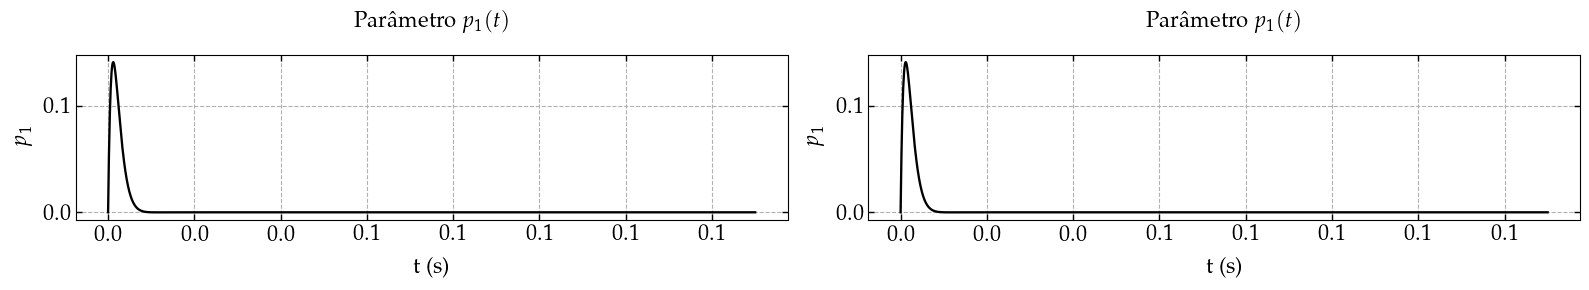

In [15]:
fig = plt.figure(figsize=(16, 3), layout='constrained')
axs = fig.subplot_mosaic([["Pl1", "Pl2"]])

gph.plot(
    axs['Pl1'],
    timepts, Pl1,
    't (s)',
    '$p_1$',
    'Parâmetro $p_1(t)$',
)
gph.plot(
    axs['Pl2'],
    timepts, Pl2,
    't (s)',
    '$p_1$',
    'Parâmetro $p_1(t)$',
)
plt.tight_layout()

In [16]:
def plant_dynamics(time, x, inputs, params):
  # Extracting the number of inputs and parameters
  n_u = 2
  n_p = 2
  n_w = 2

  # Splitting inputs into u (control inputs) and p (parameters)
  u = inputs[0:n_u][:].reshape(-1, 1)
  ρ = inputs[n_u:n_u + n_p][:].flatten()
  w = inputs[n_u + n_p: n_u + n_p + n_w][:]

  # Getting the system matrices A and B
  A = get_A(ρ, params)
  B = get_B(ρ, params)
  E = get_E(ρ, params)

  # Computing the time derivative of the state
  # s (x_dot)
  x_dot = A @ x + B @ u + E @ w

  return x_dot


def plant_output(t, x, u, params):
  return x

## Simulação da Planta em Malha Aberta

In [17]:
def openloop_simulation(x0, plant_dynamics, plant_output,
                        timepts, T_s, params):
  """
  Simula um sistema de controle em malha aberta com integração RK5.

  Args:
      x0 (np.ndarray): Estado inicial, shape (n, 1)
      plant_dynamics (callable): Dinâmica do sistema f(t, x, u, params)
      plant_output (callable): Função de saída h(t, x, u, params)
      u_til (np.ndarray): Entradas estendidas, shape (N, m, 1)
      timepts (np.ndarray): Vetor de instantes de tempo, shape (N,)
      T_s (float): Passo de simulação
      params (dict): Parâmetros do sistema

  Returns:
      list[np.ndarray]: Lista com N+1 elementos, cada um de shape (n_y, 1),
                        contendo a saída em cada instante.
  """
  N = len(timepts)
  n = x0.shape[0]

  # Inicialização do estado
  x = np.zeros((n, N, 1))
  x[:, 0, :] = x0

  y = []

  for k, t in enumerate(timepts):
    _x = x[:, k, :].flatten()
    util = np.vstack((u[k], u[k],
                      (1. / (vo[0] + _x[0])), (1. / (vo[1] + _x[1])),
                      Pl1[k], Pl2[k]))

    y.append(plant_output(t, x[:, k, :], util, dg_params))

    if k < N - 1:
      x[:, k + 1, :] = nm.rk5_step(
          plant_dynamics, t, x[:, k, :], util, T_s, dg_params
      )

  return y

In [18]:
x0 = np.array([[1.0], [0.0], [0.0], [0.0], [0.0]])
y = openloop_simulation(x0, plant_dynamics, plant_output,
                        timepts, simulation_step, dg_params)

C:\Users\andel\AppData\Local\Temp\ipykernel_12768\221372006.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


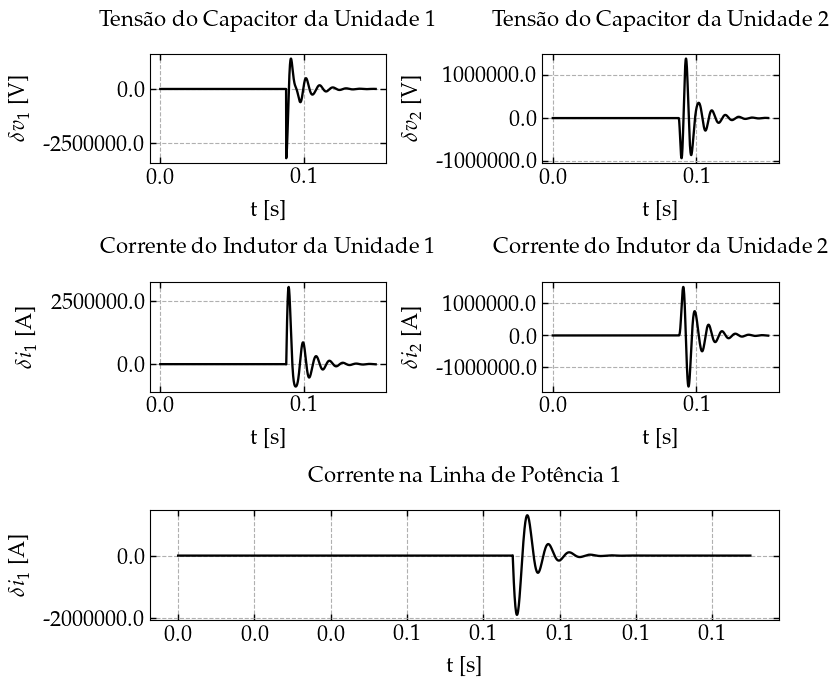

In [19]:
fig = plt.figure(figsize=(8, 7), layout='constrained')

mosaic = [['δv1', 'δv2'],
          ['δit1', 'δit2'],
          ['δi1', 'δi1']]
axs = fig.subplot_mosaic(mosaic)

for i in range(2):
  gph.plot(axs[mosaic[0][i]], timepts, [v[i] for v in y],
           't [s]', f'$\\delta v_{i+1}$ [V]',
           f'Tensão do Capacitor da Unidade {i+1}',)
for i in range(2):
  gph.plot(axs[mosaic[1][i]], timepts, [v[2+i] for v in y],
           't [s]', f'$\\delta i_{i+1}$ [A]',
           f'Corrente do Indutor da Unidade {i+1}',)
for i in range(1):
  gph.plot(axs[mosaic[2][i]], timepts, [v[4+i] for v in y],
           't [s]', f'$\\delta i_{1}$ [A]',
           f'Corrente na Linha de Potência {i+1}',)
plt.tight_layout()

In [20]:
def solve_problem(
    h: float,
    υ: float,
    δ: float,
    ε_γ: float,
    ρ_bar,
    λ: Optional[float] = None,
    θ: Optional[float] = None,
    eps: float = 1e-6,
):
  n_u = 2
  n_p = 2
  n_x = 5
  n_w = 2
  n_z = 2

  Bnp = list(itertools.product([0, 1], repeat=n_p))
  Onx = np.zeros((n_x, n_x))

  Aρ, Aϱ = {}, {}
  Bρ, Bϱ = {}, {}
  Eρ, Eϱ = {}, {}

  C = {}

  φ_bounds = np.array([[-1.0, 1.0],
                       [-1.0, 1.0]])
  ϱ_bounds = []
  for i in range(n_p):
    ϱ_bounds += [ρ_bar[i] + h * φ_bounds[i]]

  for i in Bnp:
    ρi = [ρ_bounds[idx][i[idx]] for idx in range(n_p)]
    ϱi = [ϱ_bounds[idx][i[idx]] for idx in range(n_p)]

    Aϱ[i] = cp.Parameter(
        (n_x, n_x), name=f'A[{i}]', value=get_A(ϱi, dg_params))
    Aρ[i] = cp.Parameter(
        (n_x, n_x), name=f'A[{i}]', value=get_A(ρi, dg_params))

    Bϱ[i] = cp.Parameter(
        (n_x, n_u), name=f'B[{i}]', value=get_B(ϱi, dg_params))
    Bρ[i] = cp.Parameter(
        (n_x, n_u), name=f'B[{i}]', value=get_B(ρi, dg_params))

    Eϱ[i] = cp.Parameter(
        (n_x, n_w), name=f'E[{i}]', value=get_E(ϱi, dg_params))
    Eρ[i] = cp.Parameter(
        (n_x, n_w), name=f'E[{i}]', value=get_E(ρi, dg_params))

    Ci = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                   [0.0, 1.0, 0.0, 0.0, 0.0]])
    C[i] = cp.Parameter((n_z, n_x), name=f'C[{i}]', value=Ci)

  e = nm.get_e(5 * [n_x] + [1, n_u, n_w])

  for i in range(1, len(e)):
    e[i] = cp.Parameter(e[i].shape, value=e[i], name=f"e{i}")

  constraints = []

  Ptil = cp.Variable((n_x, n_x), PSD=True)
  Mtil = cp.Variable((2 * n_x + n_u, 2 * n_x + n_u), PSD=True)
  Q1til = cp.Variable((n_x, n_x), symmetric=True)
  Q2til = cp.Variable((n_x, n_x))
  Q3til = cp.Variable((n_x, n_u))
  Q4til = cp.Variable((n_x, n_x))
  S1til = cp.Variable((n_x, n_x), symmetric=True)
  S2til = cp.Variable((n_x, n_x))
  S3til = cp.Variable((n_x, n_u))
  S4til = cp.Variable((n_x, n_x))

  Ktil = {}
  L1til = {}
  L2til = {}
  ℵ = {}

  for i in Bnp:
    Ktil[i] = cp.Variable((n_u, n_x), name=f'K[{i}]')
    L1til[i] = cp.Variable((n_u, n_x), name=f'L1[{i}]')
    L2til[i] = cp.Variable((n_u, n_x), name=f'L2[{i}]')
    ℵ[i] = cp.Variable((n_u, n_u), diag=True)
    constraints += [ℵ[i] >> eps * np.eye(ℵ[i].shape[0])]

  Rtil = cp.Variable((n_x, n_x), PSD=True)
  Ξtil = cp.Variable((n_x, n_x), PSD=True)
  Ψtil = cp.Variable((n_x, n_x), PSD=True)
  λ = cp.Parameter(value=λ)
  γ = cp.Variable(pos=True)
  δ = cp.Parameter(value=δ)
  β = cp.Variable(pos=True)
  θtil = cp.Parameter(value=(1. / θ))

  X = cp.Variable((n_x, n_x))
  Ytil = cp.Variable((2 * n_x, e[1].shape[1]))

  Rcal = cp.bmat([[Rtil, Onx],
                  [Onx, 3. * Rtil]])

  Fscr = e[1].T + υ * e[2].T + υ * e[4].T

  κ1 = cp.bmat([[e[2]], [e[7]], [e[5]]])
  κ2 = cp.bmat([[e[1] - e[2]],
                [e[1] + e[2] - 2. * e[3]]])

  def get_Λ(i, j, k):
    Bscr = Aρ[i] @ X @ e[1] + Bρ[i] @ Ktil[j] @ e[2] - \
        X @ e[4] + Bρ[i] @ Ktil[j] @ e[5] - \
        Bρ[i] @ ℵ[j] @ e[7] + γ * Eρ[i] @ e[8]

    Bscr += Aϱ[k] @ X @ e[1] + Bϱ[k] @ Ktil[j] @ e[2] + \
        Bϱ[k] @ Ktil[j] @ e[5] - Bϱ[k] @ ℵ[j] @ e[7] + γ * Eϱ[k] @ e[8]

    Θ1 = (e[1] - e[2]).T @ S1til @ (e[1] - e[2]) + \
        nm.He((e[1] - e[2]).T @ (S2til @ e[2] + S3til @ e[7] + S4til @ e[5]))

    Θ2 = nm.He(e[3].T @ (Q2til @ e[2] + Q3til @ e[7] + Q4til @ e[5]))

    Θ3 = nm.He(e[1].T @ (Q1til @ e[3] + Q2til @ e[2] +
                         Q3til @ e[7] + Q4til @ e[5]))

    Θ4 = nm.He(e[4].T @ (S1til @ (e[1] - e[2]) + S2til @
               e[2] + S3til @ e[7] + S4til @ e[5])) + \
        e[4].T @ Rtil @ e[4]

    Θ5 = e[7].T @ (ℵ[j] @ e[7] - L1til[j] @ e[2] - L2til[j] @ e[5])

    Θtil = {}
    Θtil['0'] = -λ * e[6].T @ e[6] - e[5].T @ Ξtil @ e[5] - Θ1 - \
        h * e[3].T @ Q1til @ e[3] + h * Θ3 - γ * e[8].T @ e[8] + \
        h * κ1.T @ Mtil @ κ1 + h * e[4].T @ Rtil @ e[4] - Θ5 + \
        nm.He(e[1].T @ Ptil @ e[4] + Fscr @ Bscr - κ2.T @ Ytil) + \
        h * Θ4

    Θtil['h'] = - λ * e[6].T @ e[6] - e[5].T @ Ξtil @ e[5] - Θ1 - \
        h * Θ2 - h * e[3].T @ Q1til @ e[3] - γ * e[8].T @ e[8] - \
        h * κ1.T @ Mtil @ κ1 - Θ5 + \
        nm.He(e[1].T @ Ptil @ e[4] + Fscr @ Bscr - κ2.T @ Ytil)

    Γ1_11 = Θtil['0']
    Γ1_12 = e[2].T @ X.T
    Γ1_13 = e[1].T @ X.T @ C[i].T

    Γ1_21 = Γ1_12.T
    Γ1_22 = - Ψtil
    Γ1_23 = np.zeros((n_x, n_z))

    Γ1_31 = Γ1_13.T
    Γ1_32 = Γ1_23.T
    Γ1_33 = - np.eye(n_z)

    Γ1 = cp.bmat([[Γ1_11, Γ1_12, Γ1_13],
                  [Γ1_21, Γ1_22, Γ1_23],
                  [Γ1_31, Γ1_32, Γ1_33]])

    Γ2_11 = Θtil['h']
    Γ2_12 = Ytil.T
    Γ2_13 = e[2].T @ X.T
    Γ2_14 = e[1].T @ X.T @ C[i].T

    Γ2_21 = Γ2_12.T
    Γ2_22 = - (1. / h) * Rcal
    Γ2_23 = np.zeros((2 * n_x, n_x))
    Γ2_24 = np.zeros((2 * n_x, n_z))

    Γ2_31 = Γ2_13.T
    Γ2_32 = Γ2_23.T
    Γ2_33 = - Ψtil
    Γ2_34 = np.zeros((n_x, n_z))

    Γ2_41 = Γ2_14.T
    Γ2_42 = Γ2_24.T
    Γ2_43 = Γ2_34.T
    Γ2_44 = - np.eye(n_z)

    Γ2 = cp.bmat([[Γ2_11, Γ2_12, Γ2_13, Γ2_14],
                  [Γ2_21, Γ2_22, Γ2_23, Γ2_24],
                  [Γ2_31, Γ2_32, Γ2_33, Γ2_34],
                  [Γ2_41, Γ2_42, Γ2_43, Γ2_44]])

    return Γ1, Γ2

  binary_pairs = nm.binary_pairs(n_p)

  for pairs in binary_pairs:
    LMI_SUM = {}
    LMI_SUM['0'], LMI_SUM['h'] = 0., 0.

    for k in Bnp:
      for pair in pairs:
        Λ = {}
        Λ['0'], Λ['h'] = get_Λ(pair[0], pair[1], k)
        LMI_SUM['0'] += Λ['0']
        LMI_SUM['h'] += Λ['h']

    constraints += [LMI_SUM['0'] << -eps * np.eye(LMI_SUM['0'].shape[0])]
    constraints += [LMI_SUM['h'] << -eps * np.eye(LMI_SUM['h'].shape[0])]

  for ell in range(n_u):
    for j in Bnp:
      LMISAT11 = Ptil
      LMISAT12 = np.zeros((n_x, n_x))
      LMISAT13 = np.zeros((n_x, 1))
      LMISAT14 = (Ktil[j][ell:ell+1] - L1til[j][ell:ell+1]).T
      LMISAT15 = (Ktil[j][ell:ell+1] - L1til[j][ell:ell+1]).T
      LMISAT16 = X.T

      LMISAT21 = LMISAT12.T
      LMISAT22 = Ξtil
      LMISAT23 = np.zeros((n_x, 1))
      LMISAT24 = (Ktil[j][ell:ell+1] - L2til[j][ell:ell+1]).T
      LMISAT25 = (Ktil[j][ell:ell+1] - L2til[j][ell:ell+1]).T
      LMISAT26 = np.zeros((n_x, n_x))

      LMISAT31 = LMISAT13.T
      LMISAT32 = LMISAT23.T
      LMISAT33 = (1. - θtil) * np.eye(1)
      LMISAT34 = np.zeros((1, 1))
      LMISAT35 = np.zeros((1, 1))
      LMISAT36 = np.zeros((1, n_x))

      LMISAT41 = LMISAT14.T
      LMISAT42 = LMISAT24.T
      LMISAT43 = LMISAT34.T
      LMISAT44 = (u_bar[ell] ** 2) * np.eye(1)
      LMISAT45 = np.zeros((1, 1))
      LMISAT46 = np.zeros((1, n_x))

      LMISAT51 = LMISAT15.T
      LMISAT52 = LMISAT25.T
      LMISAT53 = LMISAT35.T
      LMISAT54 = np.zeros((1, 1))
      LMISAT55 = γ * δ * (u_bar[ell] ** 2) * np.eye(1)
      LMISAT56 = np.zeros((1, n_x))

      LMISAT61 = LMISAT16.T
      LMISAT62 = LMISAT26.T
      LMISAT63 = LMISAT36.T
      LMISAT64 = LMISAT46.T
      LMISAT65 = LMISAT56.T
      LMISAT66 = Ψtil

      LMISAT = cp.bmat(
          [[LMISAT11, LMISAT12, LMISAT13, LMISAT14, LMISAT15, LMISAT16],
           [LMISAT21, LMISAT22, LMISAT23, LMISAT24, LMISAT25, LMISAT26],
           [LMISAT31, LMISAT32, LMISAT33, LMISAT34, LMISAT35, LMISAT36],
           [LMISAT41, LMISAT42, LMISAT43, LMISAT44, LMISAT45, LMISAT46],
           [LMISAT51, LMISAT52, LMISAT53, LMISAT54, LMISAT55, LMISAT56],
           [LMISAT61, LMISAT62, LMISAT63, LMISAT64, LMISAT65, LMISAT66]])

      constraints += [LMISAT >> 0]

  LMID0_11 = β * np.eye(n_x)
  LMID0_12 = np.eye(n_x)
  LMID0_21 = np.eye(n_x)
  LMID0_22 = X + X.T - Ptil

  LMID0 = cp.bmat([[LMID0_11, LMID0_12],
                   [LMID0_21, LMID0_22]])

  aq = nm.get_vertices(x_bounds)

  for i in range(len(aq)):
    LMI_D11 = Ptil
    LMI_D12 = X.T @ aq[i]
    LMI_D21 = LMI_D12.T
    LMI_D22 = np.eye(1)

    LMI_D = cp.bmat([[LMI_D11, LMI_D12],
                     [LMI_D21, LMI_D22]])

    constraints += [LMI_D >> 0]

  constraints += [Ψtil >> eps * np.eye(n_x)]
  constraints += [Ξtil >> eps * np.eye(n_x)]
  constraints += [γ >= ε_γ]

  obj = cp.Minimize(cp.trace(Ξtil + Ψtil) + β)
  prob = cp.Problem(obj, constraints)

  # Solve the problem using the MOSEK solver
  # prob.solve(solver=cp.MOSEK, verbose=False, ignore_dpp=True)
  prob.solve(solver=cp.MOSEK, verbose=False, ignore_dpp=True)

  # Initialize variables to store results
  design_results = None

  # Display the results
  if prob.status not in ["infeasible", "unbounded"]:
    Xinv = np.linalg.inv(X.value)
    Ξ = Xinv.T @ Ξtil.value @ Xinv
    Ψ = np.linalg.inv(Ψtil.value)
    P = Xinv.T @ Ptil.value @ Xinv
    S2 = Xinv.T @ S2til.value @ Xinv

    error = False

    if error == False:
      K = {}
      L1 = {}
      L2 = {}
      for i in Bnp:
        K[i] = Ktil[i].value @ Xinv
        L1[i] = L1til[i].value @ Xinv
        L2[i] = L2til[i].value @ Xinv

      etm_results = {'Ξ': Ξ, 'Ψ': Ψ, 'θ': (1. / θtil.value), 'λ': λ.value}
      design_results = {
          'optimal_value': prob.value,
          'etm': etm_results,
          'controller': {'K': K, 'L1': L1, 'L2': L2},
          'lyapunov': [P, S2],
          'bounds': [γ.value, β.value]
      }
  else:
    # print('The problem is not feasible')
    design_results = None

  return design_results

In [21]:
# Definição inicial das variáveis
Ξ = Ψ = K = L1 = P = γ = β = None
Θ, λ = None, None
optimal_value = None
δinv = 1e-4
ρ_bar = [0.15, 0.15]


# Parâmetros e resolução do problema
h, υ, ε_γ, δ, λ = 10e-4, 1e-3, 3e-5, 1. / δinv, 1e2
θ = (1. / λ) * (np.exp(λ * h) - 1) + 1
prob_res = solve_problem(h=h, υ=υ, δ=δ, ε_γ=ε_γ, λ=λ,
                         θ=θ, ρ_bar=ρ_bar, eps=1e-5)

if prob_res is not None:
  Ξ, Ψ = prob_res['etm']['Ξ'], prob_res['etm']['Ψ']
  θ, λ = prob_res['etm']['θ'], prob_res['etm']['λ']
  K, L1, L2 = prob_res['controller']['K'], prob_res['controller']['L1'], \
      prob_res['controller']['L2']
  P, S2 = prob_res['lyapunov']
  γ, β = prob_res['bounds']
  optimal_value = prob_res['optimal_value']

  # print(f'β = {β:.3e}')
  # print(f'x.T P x <= {1./β:.3e}')
  print(f'θ = {θ:.3e}')
  print(f'λ = {λ:.3e}')
  print(f'γ = {γ:.3e}')
  print(f'Induced gain = {(np.sqrt(1. / γ)):.3e}')

  display(Math(rf'\Xi = {tex.mat2tex(Ξ)}'))
  display(Math(rf'\Psi = {tex.mat2tex(Ψ)}'))

  display(Math(rf'P = {tex.mat2tex(P)}'))

  for i in nm.binary_set(2):
    display(Math(rf'K_{{{i}}} = {tex.mat2tex(K[i])}'))
    display(Math(rf'L_{{{i}}} = {tex.mat2tex(L1[i])}'))
else:
  print('Problema não é factível!')

θ = 1.001e+00
λ = 1.000e+02
γ = 3.000e-05
Induced gain = 1.826e+02


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [22]:
def closedloop_simulation(x0, η0, λ, θ, T_s):

  if (x0.T @ P @ x0).item() > 1.0:
    raise ValueError(
        "O estado inicial x0 não pertence a região de estados iniciais estimada. \n A simulação será interrompida pois os resultados não são garantidos.")

  N = len(timepts)
  nx = x0.shape[0]

  x = np.zeros((nx, N + 1, 1))
  η = np.zeros((N + 1, 1))

  x[:, 0, :] = x0
  η[0, :] = η0

  ρ0 = [x0[0][0], x0[1][0]]

  xτ = x0.copy()

  y = []
  uc = []
  ρ_hat_list = []

  ρ_hat = np.array(ρ0, dtype=np.float64).reshape(-1, 1)
  x_hat = x0
  event_times = [0.]
  trigger_async = [False]

  next_time_sampling = h

  def triggering_condition(η, x, ε, ρ):
    Tcal = x.T @ Ψ @ x - ε.T @ Ξ @ ε
    if η <= 1e-4:
      η = 0
    new_event = η + θ * Tcal[0][0] < -1e-4
    triggering_by_async = False
    if not new_event:
      for i in range(1):
        new_event = np.abs(ρ[i] - ρ_hat[i]) > ρ_bar[i]
        if new_event:
          triggering_by_async = True
          break
    return new_event, triggering_by_async

  def etm_dynamics(t, η, u, params):
    ε = x_hat - xτ
    Tcal = xτ.T @ Ψ @ xτ - ε.T @ Ξ @ ε
    η_dot = - λ * η + Tcal[0][0]
    return η_dot

  def control_signal():
    np_params = len(ρ_hat)

    # Compute alpha values
    alphas = []
    for i in range(np_params):
      rho_min, rho_max = ρ_bounds[i]
      α = (rho_max - ρ_hat[i]) / (rho_max - rho_min)
      α = np.clip(α, 0.0, 1.0)
      alphas.append(α)

    # Initialize unsaturated control signal
    vertex_keys = list(K.keys())
    n_u = K[vertex_keys[0]].shape[0]
    u_total = np.zeros((n_u, 1))

    # Convex combination over vertices
    for vertex in itertools.product([0, 1], repeat=np_params):
      weight = 1.0
      for i, v in enumerate(vertex):
        if v == 0:
          weight *= alphas[i]
        else:
          weight *= (1.0 - alphas[i])

      K_vertex = K[vertex]
      u_vertex = weight * (K_vertex @ x_hat)
      u_total += u_vertex

    # Apply saturation element-wise
    u_sat = np.zeros_like(u_total)
    for i in range(n_u):
      u_sat[i, 0] = sgn.sat(u_total[i, 0], u_bar[i])

    return u_sat

  for k, t in enumerate(timepts):
    _x = x[:, k, :].flatten()
    ρ = [_x[0], _x[1]]
    w = [Pl1[k], Pl2[k]]

    # Verificação da condição de acionamento
    if t >= next_time_sampling:
      next_time_sampling += h
      xτ = x[:, k, :]
      ε = x_hat - xτ
      new_event, triggering_by_async = triggering_condition(η[k], xτ, ε, ρ)
      if new_event:
        # print('True')
        ρ_hat = ρ
        x_hat = xτ
        event_times.append(t)
        trigger_async.append(triggering_by_async)

    # Cálculo do sinal de controle
    u_sat = control_signal().flatten()
    inputs_vec = np.vstack((u_sat[0], u_sat[1],
                            (1. / (vo[0] + _x[0])), (1. / (vo[1] + _x[1])),
                            Pl1[k], Pl2[k]))

    # Saída da planta
    y.append(plant_output(t, x[:, k, :], inputs_vec, ρ))

    # Atualização dos estados para o próximo passo (k+1)
    if k < N - 1:
      x[:, k + 1, :] = nm.rk5_step(
          plant_dynamics, t, x[:, k, :], inputs_vec, T_s, dg_params
      )
      η[k + 1, :] = nm.rk5_step(etm_dynamics, t, η[k, :], None, T_s, None)

    # Armazena controle e saída em k
    uc.append(u_sat)
    ρ_hat_list.append(ρ_hat)

  return y, uc, η[:N], event_times, trigger_async, ρ_hat_list

In [25]:
import os
import json
import numpy as np
import concurrent.futures

# Nome do arquivo de experimento
experiment_name = "Results\\Notebook-I\\ClosedLoop_Results_BuckConverter.json"
force_simulation = True
simulations_amount = 1

# Estrutura para armazenar os resultados
results_clsim = {
    'inter-event-times': [],
    'control-signal': [],
    'trajectories': [],
    'eta': [],
    'trigger_async': [],
    'ρ_hat_list': [],
}

# Função para converter arrays e listas aninhadas em estruturas serializáveis


def convert_to_serializable(obj):
  if isinstance(obj, np.ndarray):
    return obj.tolist()
  elif isinstance(obj, list):
    return [convert_to_serializable(item) for item in obj]
  elif isinstance(obj, dict):
    return {key: convert_to_serializable(val) for key, val in obj.items()}
  return obj

# Função para converter de volta para arrays


def convert_to_numpy(obj):
  return {
      'trajectories': [np.array(y_k) for y_k in obj['trajectories']],
      'control-signal': [np.array(u_k) for u_k in obj['control-signal']],
      'eta': [np.array(eta_k) for eta_k in obj['eta']],
      'inter-event-times': obj['inter-event-times'],
  }

# Função de simulação (deve existir a função closedloop_simulation no contexto)


def get_trajectories(i):
  x0 = np.array([[2.6], [2], [.0], [.0], [0]])
  η0 = np.array([[0.]])

  # Executa a simulação (substituir pelos parâmetros corretos)
  y, uc, η, event_times, trigger_async, ρ_hat_list = closedloop_simulation(
      x0, η0, λ, θ, T_s=simulation_step
  )
  inter_event_times = np.diff(event_times).tolist()

  return {
      'trajectories': y,
      'eta': η,
      'control-signal': uc,
      'inter-event-times': inter_event_times,
      'trigger_async': trigger_async,
      'ρ_hat_list': ρ_hat_list
  }


# Execução direta no notebook (ThreadPoolExecutor é seguro)
if os.path.exists(experiment_name) and not force_simulation:
  print(f"O arquivo {experiment_name} já existe. Carregando dados salvos.")
  with open(experiment_name, "r") as f:
    loaded = json.load(f)
    results_clsim = convert_to_numpy(loaded)
else:
  # Paralelismo leve e seguro para notebooks
  with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(executor.map(
        get_trajectories, range(simulations_amount)))

  # Atualizar estrutura de resultados
  for res in results:
    results_clsim['trajectories'].append(res['trajectories'])
    results_clsim['inter-event-times'].append(res['inter-event-times'])
    results_clsim['control-signal'].append(res['control-signal'])
    results_clsim['eta'].append(res['eta'])
    results_clsim['trigger_async'].append(res['trigger_async'])
    results_clsim['ρ_hat_list'].append(res['ρ_hat_list'])

  # Serializar e salvar
  results_serializable = convert_to_serializable(results_clsim)
  os.makedirs(os.path.dirname(experiment_name), exist_ok=True)

  with open(experiment_name, "w") as f:
    json.dump(results_serializable, f, indent=2)

  print(f"Simulações concluídas. Resultados salvos em {experiment_name}.")

Simulações concluídas. Resultados salvos em Results\Notebook-I\ClosedLoop_Results_BuckConverter.json.


Estado Inicial:  [2.6 2.  0.  0.  0. ]
Número de Eventos Acionados:  49
Menor IET Obtido:  0.000999999999999994
Máximo IET Obtido:  0.005999999999999998
Média do Intervalos de Tempo entre Eventos: 0.0013


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Failed to find a Ghostscript installation.  Distillation step skipped.


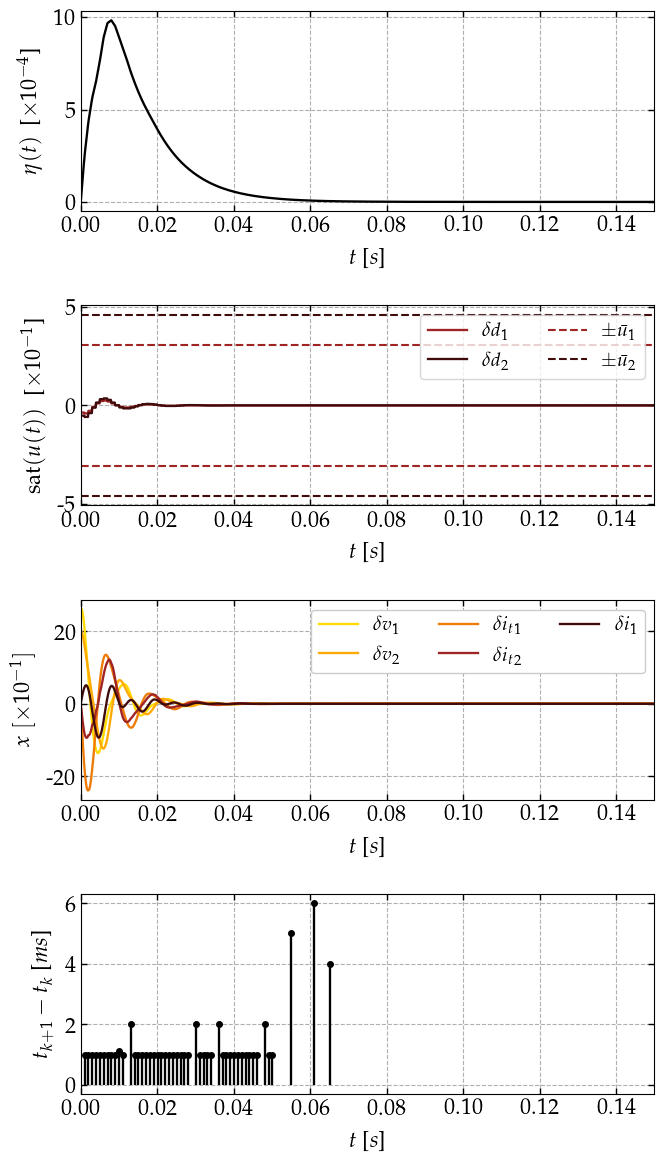

In [38]:
simulation_index = 0
inter_event_times = results_clsim['inter-event-times'][simulation_index]
uc = results_clsim['control-signal'][simulation_index]
y = results_clsim['trajectories'][simulation_index]
η = results_clsim['eta'][simulation_index]
trigger_async = results_clsim['trigger_async'][simulation_index][1:]
event_times = np.cumsum(inter_event_times)

mosaic = [['η'], ['sat'], ['x'], ['iet']]
fig, axs = plt.subplot_mosaic(mosaic, figsize=(7, 12))

t_formatted, t_unit_label, t_decimal_places = nm.format_magnitudes(
    timepts, 's', use_prefixes=True, n_divs=5)

axis_limits = {'x_min': 0., 'x_max': t_formatted[-1]}

print("Estado Inicial: ", y[0].reshape(-1))
print("Número de Eventos Acionados: ", len(inter_event_times))

if len(inter_event_times) != 0:
  print("Menor IET Obtido: ", min(inter_event_times))
  print("Máximo IET Obtido: ", max(inter_event_times))
  print(
      f"Média do Intervalos de Tempo entre Eventos: {np.mean(inter_event_times):.4f}")


n_f, n_ul, n_dp = nm.format_magnitudes(
    η, '', use_prefixes=False, n_divs=5)

gph.plot(
    axs['η'], t_formatted, n_f,
    xlabel='$t$ [$s$]', ylabel='$\\eta(t)\\,$' + n_ul,
    # title='Variável dinâmica do ETM',
    plot_cfg={**cfg,
              'axis': {**cfg['axis'], 'x_digits': t_decimal_places,
                       'y_digits': n_dp},
              'limits': {**cfg['limits'], **axis_limits},
              })


# Plot sinal de saída
gph.plot(
    axs['x'], t_formatted, [v[0] * 1e1 for v in y],
    xlabel='$t$ [$s$]', label=r'$\delta v_1$', plot_cfg={**cfg,
                                                         'style': {**cfg['style'], 'linestyle': '-', 'color': '#ffdb00'}, })

gph.plot(
    axs['x'], t_formatted, [v[1] * 1e1 for v in y],
    xlabel='$t$ [$s$]', label=r'$\delta v_2$', plot_cfg={**cfg,
                                                         'style': {**cfg['style'], 'linestyle': '-', 'color': '#ffa904'}, })

gph.plot(
    axs['x'], t_formatted, [v[2] * 1e1 for v in y],
    xlabel='$t$ [$s$]', label=r'$\delta {i_t}_1$', plot_cfg={**cfg,
                                                             'style': {**cfg['style'], 'linestyle': '-', 'color': '#ee7b06'}, })

gph.plot(
    axs['x'], t_formatted, [v[3] * 1e1 for v in y],
    xlabel='$t$ [$s$]', label=r'$\delta {i_t}_2$', plot_cfg={**cfg,
                                                             'style': {**cfg['style'], 'linestyle': '-', 'color': '#a12424'}})

gph.plot(
    axs['x'], t_formatted, [v[4] * 1e1 for v in y],
    xlabel='$t$ [$s$]', ylabel=r'$x$ $[\times 10^{-1}]$',
    # title='Estados da Planta - $x(t)$',
    label=r'$\delta i_1$',
    plot_cfg={**cfg,
              'style': {'color': '#400b0b'},
              'axis': {**cfg['axis'], 'x_digits': t_decimal_places,
                       'y_digits': 0},
              'limits': {**cfg['limits'], **axis_limits},
              'legend': {'fontsize': 14, 'ncol': 3}
              })

# Plot sinal de controle

gph.plot(
    axs['sat'], t_formatted,
    [float(v[0]) * 1e1 for v in uc],
    label=r'$\delta d_1$',
    xlabel='$t$ [$s$]', ylabel='sat$(u(t))\\;$ [$\\times 10^{-1}$]',
    plot_cfg={**cfg, 'style': {'color': '#a12424'}, })

gph.plot(
    axs['sat'], t_formatted,
    [float(v[1]) * 1e1 for v in uc],
    xlabel='$t$ [$s$]', ylabel='sat$(u(t))\\;$ [$\\times 10^{-1}$]',
    label=r'$\delta d_2$',
    plot_cfg={**cfg,
              'style': {'color': '#400b0b'},
              'axis': {**cfg['axis'], 'x_digits': t_decimal_places,
                       'y_digits': 0},
              'limits': {**cfg['limits'], **axis_limits},
              'legend': {'fontsize': 16}
              })

axs['sat'].hlines([u_bar[0] * 1e1, -u_bar[0] * 1e1],
                  0, t_formatted[-1], colors='#a12424', linestyles='--', label='$\\pm \\bar u_1$', linewidths=1.5)
axs['sat'].hlines([u_bar[1] * 1e1, -u_bar[1] * 1e1],
                  0, t_formatted[-1], colors='#400b0b', linestyles='--', label='$\\pm \\bar u_2$', linewidths=1.5)
axs['sat'].legend(prop={'size': 14}, ncol=2)


# Plot dos IETs
if len(inter_event_times) > 0:
  stem_cfg = cfg.copy()
  stem_cfg['axis']['y_digits'] = 0

  # Convertendo para milissegundos
  iet_ms = [et * 1e3 for et in inter_event_times]

  # Separando índices conforme o vetor booleano
  false_indexes = [i for i, val in enumerate(trigger_async) if not val]
  true_indexes = [i for i, val in enumerate(trigger_async) if val]

  # Eventos e tempos separados
  event_times_false = [event_times[i] for i in false_indexes]
  # print(iet_ms)
  iet_false = [iet_ms[i] for i in false_indexes]

  event_times_true = [event_times[i] for i in true_indexes]
  iet_true = [iet_ms[i] for i in true_indexes]

  # Plotando barras com cor azul para False
  if len(event_times_false) > 0:
    gph.stem(
        axs['iet'], event_times_false, iet_false,
        stem_cfg={**stem_cfg,
                  'limits': {**cfg['limits'], **axis_limits},
                  'axis': {**cfg['axis'], 'x_digits': t_decimal_places,
                           'y_digits': 0},
                  'style': {'color': '#000'}},
        xlabel='$t$ [$s$]', ylabel='$t_{k+1} - t_k$ [$ms$]',
        title='',
    )

  # Plotando barras com cor vermelha para True
  if len(event_times_true) > 0:
    gph.stem(
        axs['iet'], event_times_true, iet_true,
        stem_cfg={**stem_cfg,
                  'limits': {**cfg['limits'], **axis_limits},
                  'axis': {**cfg['axis'], 'x_digits': t_decimal_places,
                           'y_digits': 1},
                  'style': {'color': '#950101'}}
    )

else:
  axs['iet'].text(0.5, 0.5, 'No triggered events',
                  ha='center', va='center', fontsize=14,
                  transform=axs['iet'].transAxes)
  axs['iet'].set_title('Inter-event Times')
  axs['iet'].set_xlabel('Time [s]')
  axs['iet'].set_ylabel('$t_{k+1} - t_k$ [$ms$]')
  axs['iet'].set_xlim([0, simulation_time])
  axs['iet'].set_ylim([0, 1])  # valor simbólico
  axs['iet'].grid(False)

plt.tight_layout(pad=2.)
file_path = r"P:\Papers\Automatica2025\Figs\DETM_ClosedLoop_MGDC_Results.eps"
fig.savefig(file_path, format='eps', bbox_inches='tight', dpi=600)